In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import pingouin as pg

## Strategy #1: Streaky Momentum
### Description:
When stocks like Tesla start to run, they like to RUN. It's clear that when TSLA has momentum behind it, there seems to be some statistical significance in the rallies that follow.
### Hypotheses:
Null: Any random day will result in average returns over the long term.
Alternate: During momentuous moves, TSLA returns more on average. 
### Testing:
Compare average return vs. return after 5/6/7+ days of green... is it significant? Use t-test for each.

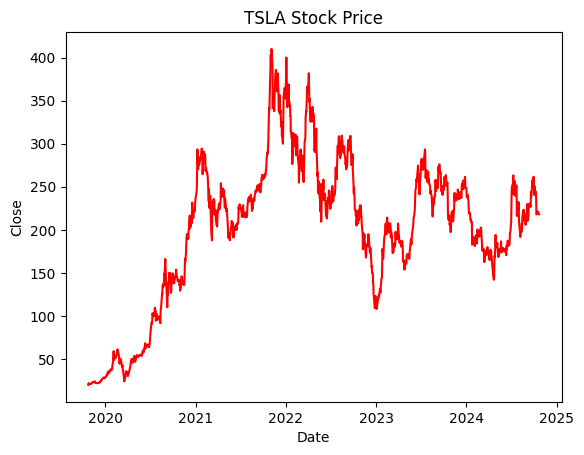

In [16]:
tsla = yf.Ticker('TSLA')
tsla_price_data = tsla.history(period='5y')['Close']
tsla_price_data.index = tsla_price_data.index.tz_localize(None)
tsla_price_data = tsla_price_data.reset_index()
tsla_price_data['Chg_Pct'] = tsla_price_data['Close'].pct_change() * 100
tsla_price_data = tsla_price_data.dropna()

sns.lineplot(data=tsla_price_data, x='Date', y='Close', color = 'red')
plt.title('TSLA Stock Price')
plt.show()

0.2893767540899162
p-value of returns by streak category is 0.020949050717145846
   Source  ddof1  ddof2         F     p-unc       np2
0  Streak     13   1241  1.958919  0.020949  0.020108


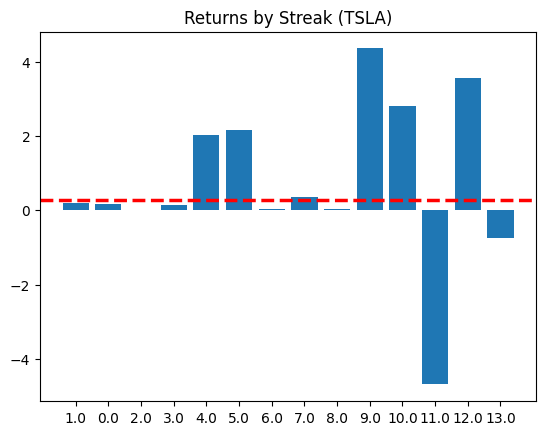

In [17]:
avg_return = tsla_price_data['Chg_Pct'].mean()
print(avg_return)

# Find all streaks
i = 1
tsla_price_data.loc[tsla_price_data.index[0], 'Streak'] = 0
while i < len(tsla_price_data) - 1:
    if tsla_price_data.loc[tsla_price_data.index[i], 'Chg_Pct'] <= 0:
        tsla_price_data.loc[tsla_price_data.index[i], 'Streak'] = 0
    else:
        tsla_price_data.loc[tsla_price_data.index[i], 'Streak'] = tsla_price_data.loc[tsla_price_data.index[i - 1], 'Streak'] + 1
    tsla_price_data.loc[tsla_price_data.index[i], 'Next Chg_Pct'] = tsla_price_data.loc[tsla_price_data.index[i + 1], 'Chg_Pct']
    i += 1

tsla_price_data = tsla_price_data.dropna()
results_streak = pg.anova(data = tsla_price_data, dv = 'Next Chg_Pct', between = 'Streak')
print('p-value of returns by streak category is {}'.format(results_streak.loc[results_streak.index[0],'p-unc']))
print(results_streak)

values = []
labels = list(tsla_price_data['Streak'].unique())
for label in labels:
    values.append(tsla_price_data.loc[tsla_price_data['Streak'] == label, 'Next Chg_Pct'].mean())
plt.bar(range(len(labels)), values, tick_label = labels)
plt.axhline(y= avg_return, linewidth=2.5, color='red', ls='--')
plt.title('Returns by Streak (TSLA)')
plt.show()

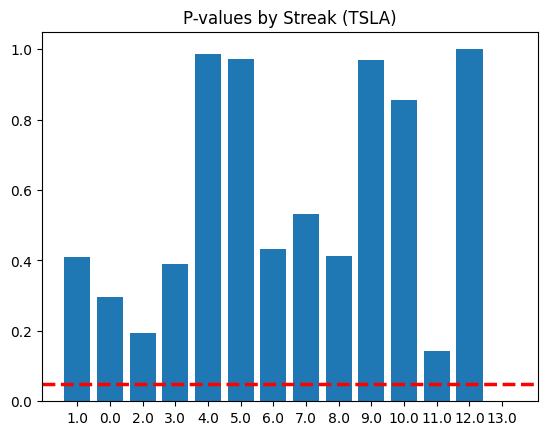

{1.0: 0.4088443826132401, 0.0: 0.2974180523108316, 2.0: 0.19257127378434818, 3.0: 0.38964785923934675, 4.0: 0.9879503964900891, 5.0: 0.9735970144264385, 6.0: 0.4327232094206467, 7.0: 0.5327892548105423, 8.0: 0.41173832555552814, 9.0: 0.9694101101513641, 10.0: 0.8548303502156441, 11.0: 0.14420547670339384, 12.0: 1.0, 13.0: 5.883844812251509e-18}


In [18]:
# Run t-tests between each streak and average returns of Tesla on any day:
x = tsla_price_data['Next Chg_Pct']

p_val_dict = {}
for label in labels:
    y = tsla_price_data.loc[tsla_price_data['Streak'] == label, 'Next Chg_Pct']
    results = pg.ttest(x, y, alternative = 'greater')
    p_val_dict[label] = results.loc[results.index[0], 'p-val']

values_p = list(p_val_dict.values())
plt.bar(range(len(labels)), values_p, tick_label = labels)
plt.axhline(y= .05, linewidth=2.5, color='red', ls='--')
plt.title('P-values by Streak (TSLA)')
plt.show()
print(p_val_dict)

## Post 2019 
Tesla trading really started to pick up post 2018... Retail trading has also picked up significantly since then.

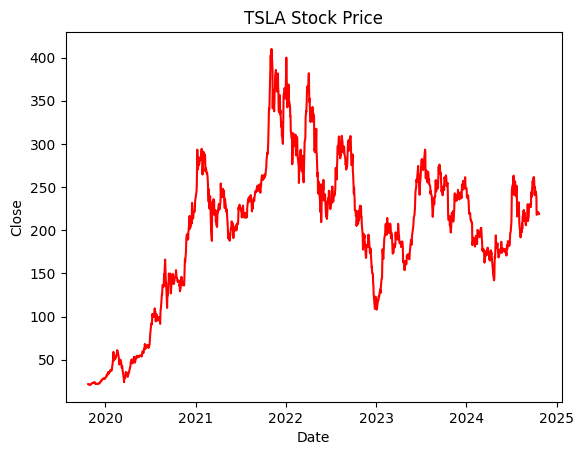

p-value of returns by streak category is 0.020949050717145846
   Source  ddof1  ddof2         F     p-unc       np2
0  Streak     13   1241  1.958919  0.020949  0.020108


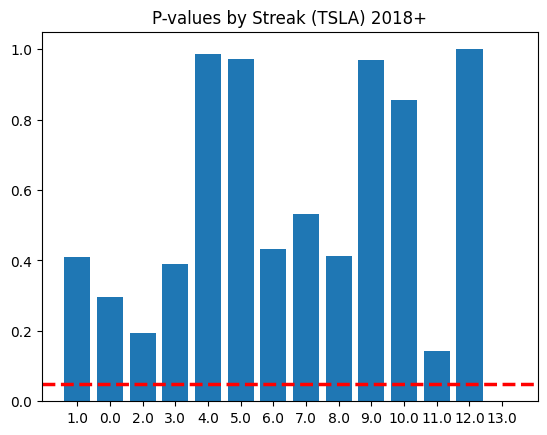

{1.0: 0.4088443826132401, 0.0: 0.2974180523108316, 2.0: 0.19257127378434818, 3.0: 0.38964785923934675, 4.0: 0.9879503964900891, 5.0: 0.9735970144264385, 6.0: 0.4327232094206467, 7.0: 0.5327892548105423, 8.0: 0.41173832555552814, 9.0: 0.9694101101513641, 10.0: 0.8548303502156441, 11.0: 0.14420547670339384, 12.0: 1.0, 13.0: 5.883844812251509e-18}


In [19]:
tsla_2018 = tsla_price_data.loc[tsla_price_data['Date'] > '2018']
sns.lineplot(data=tsla_2018, x='Date', y='Close', color = 'red')
plt.title('TSLA Stock Price')
plt.show()

results_streak_2018 = pg.anova(data = tsla_2018, dv = 'Next Chg_Pct', between = 'Streak')
print('p-value of returns by streak category is {}'.format(results_streak_2018.loc[results_streak_2018.index[0],'p-unc']))
print(results_streak_2018)

x = tsla_2018['Next Chg_Pct']

p_val_dict = {}
for label in labels:
    y = tsla_2018.loc[tsla_2018['Streak'] == label, 'Next Chg_Pct']
    results = pg.ttest(x, y, alternative = 'greater')
    p_val_dict[label] = results.loc[results.index[0], 'p-val']

values_p = list(p_val_dict.values())
plt.bar(range(len(labels)), values_p, tick_label = labels)
plt.axhline(y= .05, linewidth=2.5, color='red', ls='--')
plt.title('P-values by Streak (TSLA) 2018+')
plt.show()
print(p_val_dict)

No significance when it comes to trading TSLA streaks.

## Strategy #2: Calm Before the Storm
### Description:
Stocks tend to have very long periods of low volatility / low volume in downtrends.
### Hypotheses:
Null: Any random day will result in average returns over the long term.
Alternate: During prolonged periods of lower volume than historically average followed by periods of a quick jump in volume, Tesla will yield above average returns.
### Testing:
Compare avg returns with avg returns following a low vol --> high vol transition. Also considered price movement using moving averages. Combine two indicators and use t-test with average returns.

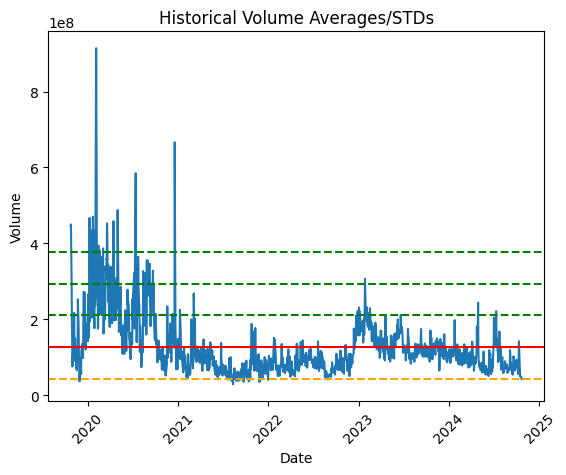

In [20]:
tsla = yf.Ticker('TSLA')
tsla_price_data = tsla.history(period='5y')
tsla_price_data.index = tsla_price_data.index.tz_localize(None)
tsla_price_data = tsla_price_data.reset_index()
tsla_price_data['Chg_Pct'] = tsla_price_data['Close'].pct_change() * 100
tsla_price_data = tsla_price_data.dropna()

avg_vol_historical = np.average(tsla_price_data['Volume'])
std_vol_historical = np.std(tsla_price_data['Volume'])

sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Volume')
plt.xticks(rotation=45)
plt.axhline(y = avg_vol_historical, color = 'red')
plt.axhline(y = avg_vol_historical - std_vol_historical, color = 'orange', ls = '--')
plt.axhline(y = avg_vol_historical + std_vol_historical, color = 'green', ls = '--')
plt.axhline(y = avg_vol_historical + 2 * std_vol_historical, color = 'green', ls = '--')
plt.axhline(y = avg_vol_historical + 3 * std_vol_historical, color = 'green', ls = '--')
plt.title('Historical Volume Averages/STDs')
plt.show()

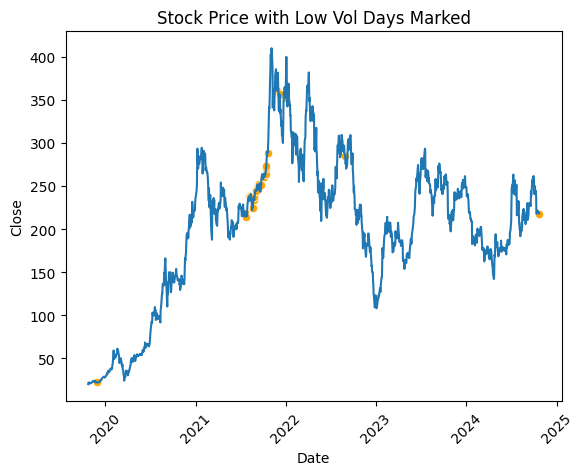

In [21]:
# Historical Volume - may not be completely relevant to recent volumes, times change

high_vol = tsla_price_data.loc[tsla_price_data['Volume'] > avg_vol_historical + 2 * std_vol_historical]
low_vol = tsla_price_data.loc[tsla_price_data['Volume'] < avg_vol_historical - std_vol_historical]

sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Close')
sns.scatterplot(data = low_vol, x = 'Date', y = 'Close', color = 'orange')
plt.xticks(rotation=45)
plt.title('Stock Price with Low Vol Days Marked')
plt.show()

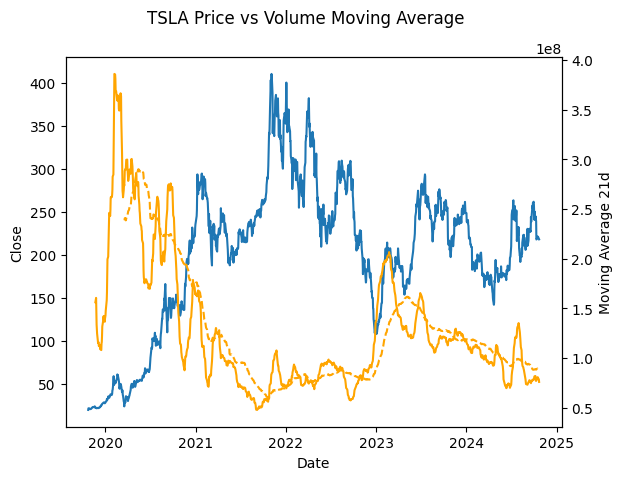

In [22]:
window_size_small = 21
window_size_long = 100

def createMovingStatistics(df, window_size, descriptor, col, rounding = True):
    # take a df, the size of window, and descriptor of time duration, return a df with additional columns
    i = 0
    while i < len(tsla_price_data) - window_size:
        window = df.loc[i : i + window_size, col]
        if rounding == True:
            window_vol_avg = round(np.average(window), 0)
            window_vol_std = round(np.std(window), 0)
        if rounding == False:
            window_vol_avg = np.average(window)
            window_vol_std = np.std(window)
        df.loc[i + window_size + 1, 'Moving Average {}'.format(descriptor)] = window_vol_avg
        df.loc[i + window_size + 1, 'Moving STD {}'.format(descriptor)] = window_vol_std
        i += 1

createMovingStatistics(tsla_price_data, window_size_small, '21d', 'Volume')
createMovingStatistics(tsla_price_data, window_size_long, '100d', 'Volume')
createMovingStatistics(tsla_price_data, window_size_long, '100d AVG', 'Close', False)

fig, ax = plt.subplots()
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Close')
ax2 = plt.twinx()
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 21d', color = 'orange', ax = ax2)
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 100d', color = 'orange', ax = ax2, linestyle= '--')
fig.suptitle('TSLA Price vs Volume Moving Average')

# MSD - Moving Standard Deviation --> Assumption is we expect the std to change over time

std_dev_long = np.std(tsla_price_data['Moving Average 100d'])
tsla_price_data['Moving Average 100d +1STD'] = tsla_price_data['Moving Average 100d'] +  tsla_price_data['Moving STD 21d']
tsla_price_data['Moving Average 100d -1STD'] = tsla_price_data['Moving Average 100d'] - tsla_price_data['Moving STD 21d']

plt.show()

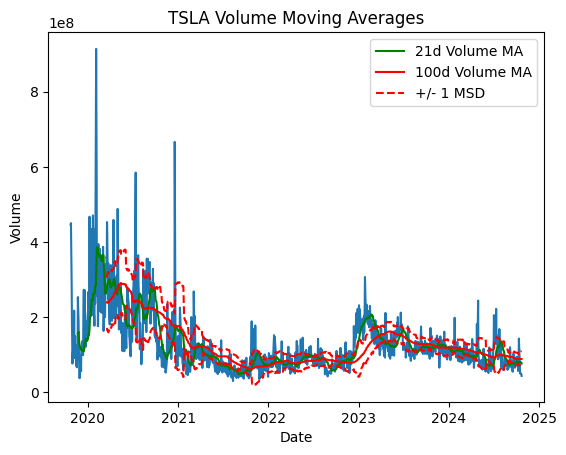

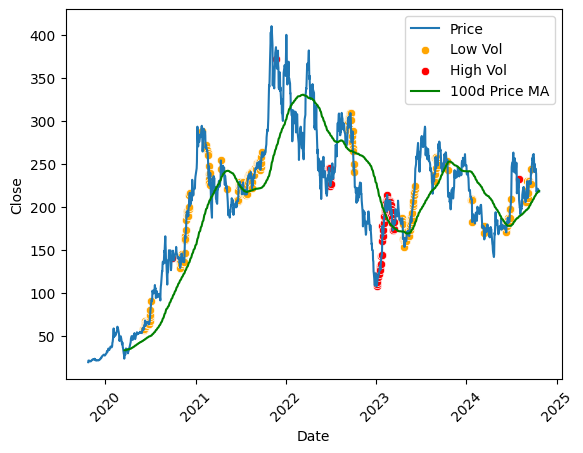

In [23]:
# Look at how the two volume lines compare
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Volume')
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 21d', color = 'green', label = '21d Volume MA')
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 100d', color = 'red', label = '100d Volume MA')
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 100d +1STD', color = 'red', linestyle= '--', label = '+/- 1 MSD')
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 100d -1STD', color = 'red', linestyle= '--')
plt.title('TSLA Volume Moving Averages')
plt.legend()

plt.show()

high_vol = tsla_price_data.loc[tsla_price_data['Moving Average 21d'] > tsla_price_data['Moving Average 100d +1STD']]
low_vol = tsla_price_data.loc[tsla_price_data['Moving Average 21d'] < tsla_price_data['Moving Average 100d -1STD']]

sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Close', label = 'Price')
sns.scatterplot(data = low_vol, x = 'Date', y = 'Close', color = 'orange', label = 'Low Vol')
sns.scatterplot(data = high_vol, x = 'Date', y = 'Close', color = 'red', label = 'High Vol')
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 100d AVG', color = 'green', label = '100d Price MA')
plt.legend()
plt.xticks(rotation=45)
plt.show()

It appears that combined with the signal of relatively low volume, when the 100d moving avg is turning from neg to pos (derivative <0 to >0), there is some serious correlation... let's check.

In [24]:
tsla_price_data['Moving Average deriv'] = tsla_price_data['Moving Average 100d AVG'].diff()

# Add new column : Avg Checker (1 if moving avg has flipped in last 14? days)
# have to start iterating at the moving average day count (because the moving average is calculated from the previous x days) 
# + moving avg window because we are checking 14 days behind the current i value
moving_avg_days = 100
moving_avg_flip_window = 14
i = moving_avg_flip_window + moving_avg_days
while i < len(tsla_price_data):
    if tsla_price_data.loc[i, 'Moving Average deriv'] < 0:
        tsla_price_data.loc[i, 'Moving Average CHECKER'] = 0
    if tsla_price_data.loc[i, 'Moving Average deriv'] >= 0:
        j = 1
        while j <= moving_avg_flip_window:
            if tsla_price_data.loc[i - j, 'Moving Average deriv'] < 0:
                tsla_price_data.loc[i, 'Moving Average CHECKER'] = 1
                break
            else:
                tsla_price_data.loc[i, 'Moving Average CHECKER'] = 0
            j += 1
    i += 1

print(np.sum(tsla_price_data['Moving Average CHECKER'].isna()))
print(np.sum(tsla_price_data['Moving Average CHECKER'].notna()))
print(tsla_price_data['Moving Average CHECKER'].value_counts())

114
1143
Moving Average CHECKER
0.0    1036
1.0     107
Name: count, dtype: int64


Results (BEFORE MOVING AVG CROSSOVER ADDED):
There were 251 trade signals.
Successful trades: 176
Failed trades: 75
Avg Return: 4.66%

Results (AFTER):
There were 50 trade signals.
Successful trades: 37
Failed trades: 13
Avg Return: 4.9%


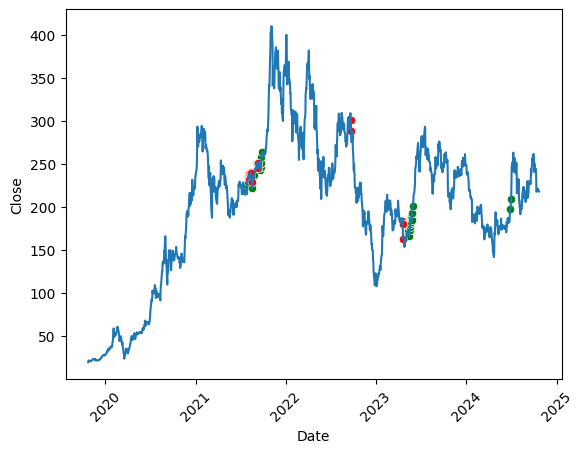

In [25]:
# This will calculate the following 7 day return of ALL data points
forward_return_days = 7
i = forward_return_days
while i < len(tsla_price_data) - forward_return_days:
    tsla_price_data.loc[i, 'Following 7d Return'] = np.sum(tsla_price_data.loc[i : i + forward_return_days, 'Chg_Pct'])
    i += 1

# Get cumulative return over next 7 days after signal --> low_vol indices are all signal points in price df
low_vol_indices = low_vol.index

trades_before = tsla_price_data[tsla_price_data.index.isin(low_vol_indices)]
trade_opportunities = len(trades_before)
pos_trades = len(trades_before[trades_before['Following 7d Return'] > 0])
neg_trades = len(trades_before[trades_before['Following 7d Return'] <= 0])
avg_return = round(np.average(trades_before['Following 7d Return']), 2)

print('Results (BEFORE MOVING AVG CROSSOVER ADDED):')
print('There were {} trade signals.'.format(trade_opportunities))
print('Successful trades: {}'.format(pos_trades))
print('Failed trades: {}'.format(neg_trades))
print('Avg Return: {}%'.format(avg_return))

trades_after = trades_before[trades_before['Moving Average CHECKER'] == 1]
trade_opportunities = len(trades_after)
pos_trades = trades_after[trades_after['Following 7d Return'] > 0]
neg_trades = trades_after[trades_after['Following 7d Return'] <= 0]
avg_return = round(np.average(trades_after['Following 7d Return']), 2)

print('\nResults (AFTER):')
print('There were {} trade signals.'.format(trade_opportunities))
print('Successful trades: {}'.format(len(pos_trades)))
print('Failed trades: {}'.format(len(neg_trades)))
print('Avg Return: {}%'.format(avg_return))

sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Close')
sns.scatterplot(data = pos_trades, x = 'Date', y = 'Close', color = 'green')
sns.scatterplot(data = neg_trades, x = 'Date', y = 'Close', color = 'red')
plt.xticks(rotation=45)
plt.show()

TEST for statistical significance or just luck:

In [26]:
returns = tsla_price_data['Following 7d Return']
returns = returns.dropna()

x = trades_after['Following 7d Return']
y = returns
results = pg.ttest(x, y, alternative = 'greater')
results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.772667,54.507178,greater,0.040936,"[0.15, inf]",0.221783,1.357,0.456982


23.703925124693747


/var/folders/nf/pgqkpvdj1l9cmj9rldvv2f6c0000gn/T/ipykernel_41891/4250928839.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( returns )


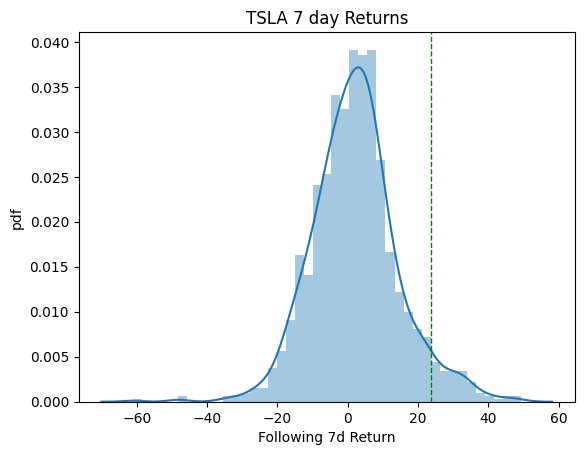

In [27]:
threshold = np.quantile(returns, .95)
print(threshold)
plt.title( 'TSLA 7 day Returns' )  
plt.ylabel( 'pdf' )  
sns.distplot( returns )  
plt.axvline(x= threshold, linewidth=1, color='green', ls='--')
plt.show()  

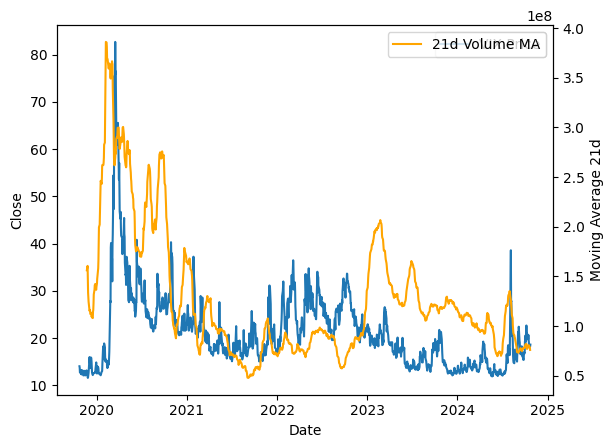

Text(0.5, 0.98, 'Volume vs. Volatility Index')

In [28]:
vix = yf.Ticker('^VIX')
vix_data = vix.history(period='5y')
vix_data.index = vix_data.index.tz_localize(None)
vix_data = vix_data.reset_index()

fig, ax = plt.subplots()
sns.lineplot(data = vix_data, x = 'Date', y = 'Close', label = 'VIX Price')
ax2 = plt.twinx()
sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 21d', color = 'orange', ax = ax2, label = '21d Volume MA')
# sns.lineplot(data = tsla_price_data, x = 'Date', y = 'Moving Average 100d', color = 'red', ax = ax2, linestyle= '--')
plt.legend()
plt.show()
fig.suptitle('Volume vs. Volatility Index')